<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

## <center> Assignment 4. Sarcasm detection with logistic regression
    
We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 
<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

In [1]:
!ls ../input/sarcasm/

"ls" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


In [2]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
train_df = pd.read_csv('../data/train-balanced-sarcasm.csv')

In [4]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Some comments are missing, so we drop the corresponding rows.

In [6]:
train_df.dropna(subset=['comment'], inplace=True)

We notice that the dataset is indeed balanced

In [86]:
train_df['label'].value_counts() # данных достаточно и тех и тех

0    505405
1    505368
Name: label, dtype: int64

We split data into training and validation parts.

In [19]:
train_df['comment_transformed'] =  train_df['comment'].apply(lambda x: x.lower())
train_df['comment_transformed'] = train_df['comment_transformed'].apply(lambda x: x.replace('.','').replace(',','').replace('+','').replace('-','').replace('!','').replace('?','').replace('-','').strip())
#good_flattened
train_df.tail()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,comment_transformed
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,...",i'm sure that iran and n korea have the techno...
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...,whatever you do don't vote green
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...,perhaps this is an atheist conspiracy to make ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...,the slavs got their own country it is called ...
1010825,1,"values, as in capitalism .. there is good mone...",frogking,politics,2,2,0,2009-01,2009-01-24 06:20:14,Why do the people who make our laws seem unabl...,values as in capitalism there is good money i...


In [85]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train_df[['comment', 'comment_transformed']], train_df['label'], random_state=17)
y_train.value_counts(), y_valid.value_counts() # разбили более-менее равномерно

(0    379097
 1    378982
 Name: label, dtype: int64,
 1    126386
 0    126308
 Name: label, dtype: int64)

## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

## Links:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions

In [21]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [22]:
from wordcloud import WordCloud, STOPWORDS
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly import tools
train1_df = train_df[train_df["label"]==1]
train0_df = train_df[train_df["label"]==0]

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS ]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from sincere questions ##
from collections import defaultdict
freq_dict = defaultdict(int)
for sent in train0_df["comment_transformed"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'lightblue')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train1_df["comment_transformed"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of non-sarcasm questions", 
                                          "Frequent words of sarcasm questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots')

C:\Users\Eskander\Anaconda3\lib\site-packages\plotly\tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer

v = TfidfVectorizer(stop_words=STOPWORDS, ngram_range=(1,2), min_df=1)
x = v.fit_transform(train_df['comment_transformed'])

C:\Users\Eskander\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.



In [88]:
x_tr, x_te, y_tr, y_te = train_test_split(x,train_df['label'], shuffle=False, random_state=42)
y_tr.mean(), y_te.mean() # данные разбиты равномерно

(0.4860298201110966, 0.5418371627343744)

In [61]:
model = LogisticRegression(random_state=42, max_iter=1000, verbose=1, n_jobs=10)
model.fit(x_tr, y_tr)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  2.0min finished


LogisticRegression(max_iter=1000, n_jobs=10, random_state=42, verbose=1)

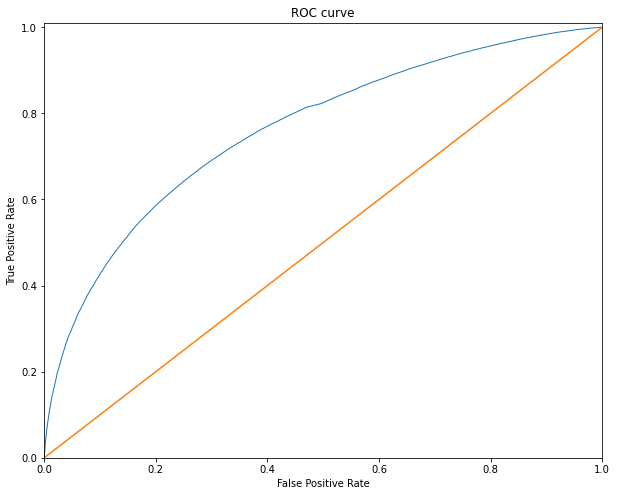

array([1.99996555, 0.99996555, 0.99984987, ..., 0.0086902 , 0.00759886,
       0.00727676])

In [62]:
y_pr = model.predict_proba(x_te)
from sklearn.metrics import roc_curve, roc_auc_score
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_te.astype('int'), y_pr[:,1], pos_label=1)
lw = 1
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1],[0, 1])
plt.xlim([0.0, 1.])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()
thresholds

In [63]:
model.score(x_te, y_te)

0.6900876158515833

#### Learning with the help of gridsearch and pipeline

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
pipeline = Pipeline([
    ('tf_idf', v),
    ('logit', model)
])
params = {'tf_idf__min_df': [1,2,None],
          'logit__C': [0.1, 0.4, 0.7, 1]}
gridsearch = GridSearchCV(estimator=pipeline , param_grid=params, verbose=1, n_jobs=10, cv=[(slice(None), slice(None))])
gridsearch.fit(train_texts['comment_transformed'], y_train)

Fitting 1 folds for each of 12 candidates, totalling 12 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   6 out of  12 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=10)]: Done  12 out of  12 | elapsed:  6.2min finished
C:\Users\Eskander\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning:

Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 out of   1 | elapsed:  2.6min finished


GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=Pipeline(steps=[('tf_idf',
                                        TfidfVectorizer(ngram_range=(1, 2),
                                                        stop_words={'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'all',
                                                                    'also',
                                                                    'am', 'an',
                                                                    'and',
                                      

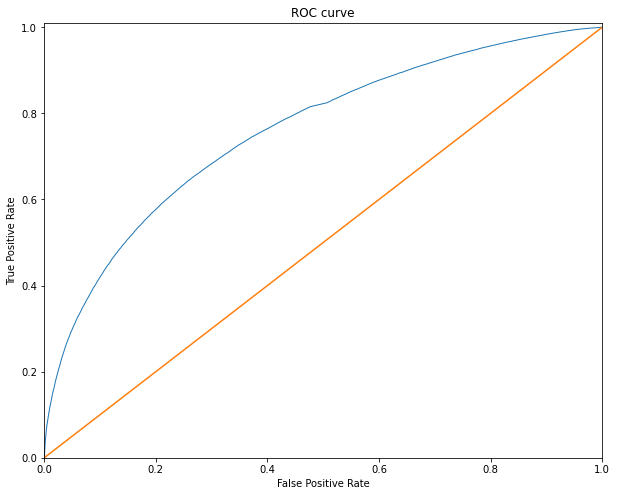

array([1.99996585e+00, 9.99965846e-01, 9.99958184e-01, ...,
       6.96575998e-03, 6.68917773e-03, 1.70050564e-03])

In [30]:
y_valid_predicted = gridsearch.predict_proba(valid_texts['comment_transformed'])
from sklearn.metrics import roc_curve, roc_auc_score
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_valid.astype('int'), y_valid_predicted[:,1], pos_label=1)
lw = 1
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1],[0, 1])
plt.xlim([0.0, 1.])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()
thresholds

In [28]:
max_index = np.argmax(tpr-fpr)
roc_score = roc_auc_score(y_te.astype('int'), y_pr[:,1])
print('порог - '+ str(thresholds[max_index])) 
print('true positive rate(recall) - '+ str(tpr[max_index]))# 
print('false positive rate - '+ str(fpr[max_index]))
print('roc score - ' +str(roc_score))

порог - 0.47721227674635236
true positive rate(recall) - 0.6706519913233372
false positive rate - 0.278013388037141
roc score - 0.7621757768226813


In [31]:
max_index = np.argmax(tpr-fpr)
roc_score = roc_auc_score(y_valid.astype('int'), y_valid_predicted[:,1])
print('порог - '+ str(thresholds[max_index])) 
print('true positive rate(recall) - '+ str(tpr[max_index]))# 
print('false positive rate - '+ str(fpr[max_index]))
print('roc score - ' +str(roc_score))

порог - 0.5255971116864439
true positive rate(recall) - 0.6443751681357113
false positive rate - 0.25887513063305573
roc score - 0.7589413811316079


In [33]:
gridsearch.score(valid_texts['comment_transformed'],y_valid )

0.6916547286441308

In [34]:
gridsearch.best_params_ 

{'logit__C': 1, 'tf_idf__min_df': 1}

### Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)

In [35]:
pip install eli5


Note: you may need to restart the kernel to use updated packages.


In [36]:
import eli5
eli5.show_weights(model, feature_names=v.get_feature_names(), target_names=['non-sarcastic', 'sarcastic'])

C:\Users\Eskander\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

C:\Users\Eskander\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.



Weight?,Feature
+10.721,obviously
+9.755,clearly
+9.249,totally
+6.864,duh
+6.254,shitlord
+6.020,dare
+5.992,bbut
+5.916,gee
+5.842,forgot
+5.836,yeah


In [37]:
train_df['comment_transformed'][185]

"they gave us 71 free packs that's not an opinion it's a fact"

In [38]:
eli5.show_prediction(model, train_df['comment_transformed'][185], vec=v,
                     target_names=['non-sarcastic', 'sarcastic'])


###  Add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

In [64]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

subreddits_bag_of_words = cv.fit_transform(train_df['subreddit'])

In [65]:
subreddits_bag_of_words.shape, x.shape

((1010773, 14877), (1010773, 2872047))

In [66]:
import scipy
data_2 = scipy.sparse.hstack([x, subreddits_bag_of_words])
data_2.shape

(1010773, 2886924)

In [67]:
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(data_2, train_df['label'], shuffle=False, random_state=42)

In [68]:
data_2.max(),data_2.min()

(1.0, 0.0)

In [69]:
logit_2 = LogisticRegression(random_state=42, n_jobs=10)
params = {'C': [0.1, 0.4, 1]}
model_2 = GridSearchCV(estimator=logit_2, param_grid=params, verbose=1, n_jobs=10,  cv=[(slice(None), slice(None))])
model_2.fit(x_train_2, y_train_2)

Fitting 1 folds for each of 3 candidates, totalling 3 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of   3 | elapsed:  1.5min finished


GridSearchCV(cv=[(slice(None, None, None), slice(None, None, None))],
             estimator=LogisticRegression(n_jobs=10, random_state=42),
             n_jobs=10, param_grid={'C': [0.1, 0.4, 1]}, verbose=1)

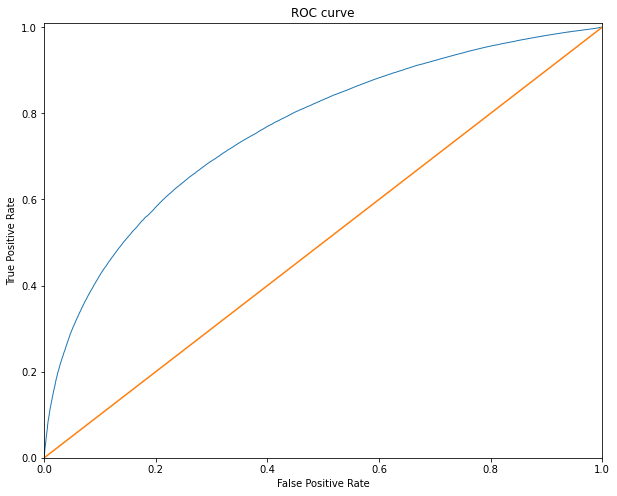

array([1.99982584, 0.99982584, 0.99977583, ..., 0.00471022, 0.00466469,
       0.00243815])

In [70]:
y_predicted_2 = model_2.predict_proba(x_test_2)
from sklearn.metrics import roc_curve, roc_auc_score
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test_2.astype('int'), y_predicted_2[:,1], pos_label=1)
lw = 1
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1],[0, 1])
plt.xlim([0.0, 1.])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()
thresholds

In [71]:
max_index = np.argmax(tpr-fpr)
roc_score = roc_auc_score(y_te.astype('int'), y_predicted_2[:,1])
print('порог - '+ str(thresholds[max_index])) 
print('true positive rate(recall) - '+ str(tpr[max_index]))# 
print('false positive rate - '+ str(fpr[max_index]))
print('roc score - ' +str(roc_score))

порог - 0.4938200830239622
true positive rate(recall) - 0.652115484337455
false positive rate - 0.2603584538976463
roc score - 0.7617928318850293


In [72]:
model_2.score(x_test_2, y_test_2)

0.6907761957149754